In [26]:
#configure dataset
from os import listdir

directory_name = "./the-simpsons-characters-dataset/kaggle_simpson_testset"
image_names = listdir(directory_name)
image_names.remove('.DS_Store')
print(image_names[:5])


['abraham_grampa_simpson_0.jpg', 'abraham_grampa_simpson_1.jpg', 'abraham_grampa_simpson_10.jpg', 'abraham_grampa_simpson_11.jpg', 'abraham_grampa_simpson_12.jpg']


Shape:(90, 56, 3)


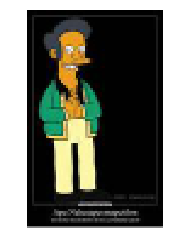

Shape:(166, 114, 3)


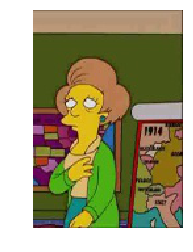

Shape:(176, 156, 3)


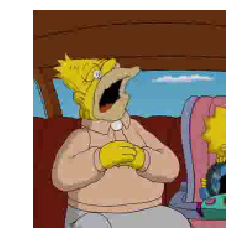

Shape:(154, 103, 3)


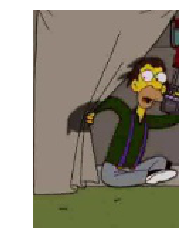

Shape:(154, 206, 3)


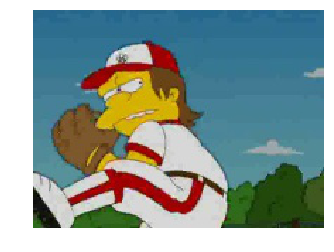

In [35]:
#load an image
import os, random
from scipy.misc import imread, toimage
import matplotlib.pyplot as plt

images_size = len(image_names)

for i in range(1,6):
    image_idx = random.randint(0, images_size)
    path_file = os.path.join(directory_name, image_names[image_idx])
    image = imread(path_file)
    print("Shape:{}".format(image.shape))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
